In [3]:
import re
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Dense,
    Flatten,
    Concatenate,
    Multiply,
    Attention,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-06-10 11:49:33.160310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#Users
u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
items = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/Users/alisatodorova/surfdrive/Year 1/Deep Learning/Project/dataset/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [ ]:
# users.head(10)

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [6]:
# Dropping the header row
users.drop(users.index[0], inplace=True)
items.drop(items.index[0], inplace=True)
ratings.drop(ratings.index[0], inplace=True)

In [ ]:
# users.head()

In [ ]:
# items.head()

In [ ]:
# ratings.head()

In [7]:
# Merge the three forms of data
df = pd.merge(users, ratings, on="user_id")

df = pd.merge(items, df, on="isbn")
# df.head()

In [ ]:
# df.shape

In [ ]:
# df.describe()

In [ ]:
# df.info()

In [8]:
# Check for missing values
df.isnull().sum()

isbn                        0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   2
img_s                       0
img_m                       0
img_l                       0
user_id                     0
location                    0
age                    277845
rating                      0
dtype: int64

In [9]:
# Drop the missing values
df.dropna(inplace=True)
df.isnull().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
img_s                  0
img_m                  0
img_l                  0
user_id                0
location               0
age                    0
rating                 0
dtype: int64

In [ ]:
# df.info()

In [10]:
# Convert the data types
df["user_id"] = df["user_id"].astype(int)
df["isbn"] = df["isbn"].astype(str)
df["rating"] = df["rating"].astype(float)
df["year_of_publication"] = df["year_of_publication"].astype(int)

In [11]:
# Re-index user_id and isbn
user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
isbn_mapping = {isbn: idx for idx, isbn in enumerate(df["isbn"].unique())}

df["user_id"] = df["user_id"].map(user_id_mapping)
df["isbn"] = df["isbn"].map(isbn_mapping)

In [ ]:
# # Authors with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=df['book_author'].value_counts().head(50), y=df['book_author'].value_counts().head(50).index)
# plt.xlabel("Count")
# plt.ylabel("Author")
# plt.title("Authors with Most Ratings", size=20)

In [ ]:
# ds = df["book_title"].value_counts().head(50).reset_index()
# ds.columns = ["book", "count"]
# ds.head()

In [ ]:
# # Books with most ratings
# plt.figure(figsize=(12, 12))
# sns.barplot(x=ds['count'], y=ds['book'])
# plt.xlabel("Count")
# plt.ylabel("Book")
# plt.title("Books with Most Ratings", size=20)

# Split the dataset into training, validation, and test sets

In [12]:
# Split the dataset into training, validation, and test sets
# Splits the original dataset df into two parts: 80% of the data is assigned to train, and 20% is assigned to test.
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Splits the train dataset into two parts: 80% of the data is assigned to train, and 20% is assigned to val.
train, val = train_test_split(train, test_size=0.2, random_state=42)
# In the end, we have train: 64% of the original dataset, val: 16% of the original dataset, test: 20% of the original dataset.

In [13]:
# Extracting the input arrays
user_ids_train = train["user_id"].values
item_ids_train = train["isbn"].values
ratings_train = train["rating"].values.astype(float)
user_ids_val = val["user_id"].values
item_ids_val = val["isbn"].values
ratings_val = val["rating"].values.astype(float)

In [14]:
# Verify data types and ranges
print(user_ids_train.dtype)  # Should be integer type
print(item_ids_train.dtype)  # Should be integer type
print(ratings_train.dtype)  # Should be float type

print(
    user_ids_train.max(), len(user_id_mapping)
)  # Max value should be less than len(user_id_mapping)
print(
    item_ids_train.max(), len(isbn_mapping)
)  # Max value should be less than len(isbn_mapping)

int64
int64
float64
53887 53888
229012 229013


In [29]:
# Matrix Factorization with Neural Networks (MF-NN)
# This leverages collaborative filtering with deep learning for user-item interaction modeling.


# Define MF-NN Model
def mf_nn_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    concat = Concatenate()([user_vector, item_vector])

    dense = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(concat)
    dense = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(), loss="mse")

    return model

In [30]:
num_users = len(user_id_mapping)
num_items = len(isbn_mapping)
# This is the dimension of the embedding vectors for both users and items.
# It determines the size of the latent factors space where users and items are projected. A higher dimension can capture more complex interactions but also increases the computational complexity and risk of overfitting.
embedding_dim = 20

In [31]:
# Train the MF-NN model
model_mf_nn = mf_nn_model(num_users, num_items, embedding_dim)
model_mf_nn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 20)     │  1,077,760 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 20)     │  4,580,260 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 20)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 20)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │      5,248 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,671,589 (21.64 MB)

 Trainable params: 5,671,589 (21.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Callbacks for better training
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.001)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model_mf_nn.fit(
    [user_ids_train, item_ids_train],
    ratings_train,
    epochs=50,  # Increased number of epochs for monitoring
    batch_size=32,
    validation_data=([user_ids_val, item_ids_val], ratings_val),
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2102s 139ms/step - loss: 14.2944 - val_loss: 13.0075 - learning_rate: 0.0010
Epoch 2/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2095s 139ms/step - loss: 12.9540 - val_loss: 12.9081 - learning_rate: 0.0010
Epoch 3/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2092s 139ms/step - loss: 12.7113 - val_loss: 12.7151 - learning_rate: 0.0010
Epoch 4/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2123s 141ms/step - loss: 12.6952 - val_loss: 12.7040 - learning_rate: 0.0010
Epoch 5/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2116s 140ms/step - loss: 12.7070 - val_loss: 12.7924 - learning_rate: 0.0010
Epoch 6/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2123s 141ms/step - loss: 12.6335 - val_loss: 12.6424 - learning_rate: 0.0010
Epoch 7/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2116s 140ms/step - loss: 12.6443 - val_loss: 12.6844 - learning_rate: 0.0010
Epoch 8/50
15067/15067 ━━━━━━━━━━━━━━━━━━━━ 2117s 141ms/step - loss: 12.6392 - val_loss: 12.8839 - learning_rate: 0.0010
Epoch 9/50
15067/15067 ━━━━━━━━━

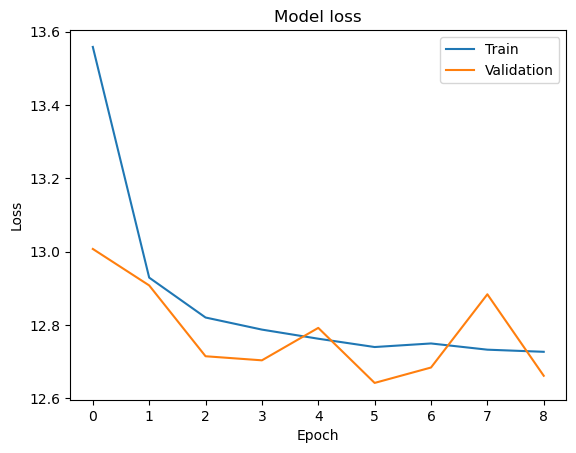

In [16]:
# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [17]:
# Evaluate and compare performance on test set
user_ids_test = test["user_id"].astype(int).values
item_ids_test = test["isbn"].astype(int).values
ratings_test = test["rating"].astype(float).values
test_loss = model_mf_nn.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 117s 25ms/step - loss: 12.6409
Test Loss: 12.671831130981445


In [18]:
# Evaluate on the validation set
val_loss = model_mf_nn.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 91s 24ms/step - loss: 12.6652
Validation Loss: 12.642430305480957


In [19]:
# Optionally, predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_mf_nn.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_mf_nn.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

3767/3767 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step
Prediction Validation: [[6.361823  ]
 [3.5335205 ]
 [3.2089224 ]
 ...
 [0.47610015]
 [1.0931821 ]
 [0.7685995 ]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step
Prediction Test: [[0.768944  ]
 [5.053342  ]
 [1.4767392 ]
 ...
 [3.4158003 ]
 [2.259014  ]
 [0.52226675]]
Validation RMSE: 3.4117125746808528, Test RMSE: 3.4160195493273453


# Book recommendations

In [20]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_mf_nn.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)

2134/2134 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step
Top 10 Recommended Books for User 3885
                                             book_title          book_author
5225        Garzanti - Gli Elefanti: Creatura Di Sabbia        T Ben Jelloun
5160    Tapestry Of Fate (Harlequin Historical, No 246)        Nina Beaumont
2661  How to Talk So Kids Will Listen and Listen So ...          Adele Faber
2015  Afrikanisches Fieber. Erfahrungen aus vierzig ...  Ryszard Kapuscinski
6025                A Grave Denied: A Kate Shugak Novel        Dana Stabenow
1403                                       Hiding Place      Corrie Ten Boom
2872  The Tao of Bada Bing: Words of Wisdom from the...          David Chase
2155                                  Hot Off the Press         Nancy Warren
1976                           White Oleander : A Novel          Janet Fitch
26                             Flood : Mississippi 1927        Kathleen Duey


In [21]:
user_id = 3885
# Get the indices of the highest rated books for a particular user from the test set
# Specify the user ID here
user_test_indices = np.where(user_ids_test == user_id)[0]
user_test_ratings = ratings_test[user_test_indices]
highest_rated_indices = np.argsort(user_test_ratings)[-10:][
    ::-1
]  # Get indices of top 10 highest rated books

# Map indices back to book titles and authors
highest_rated_books = items.iloc[
    item_ids_test[user_test_indices[highest_rated_indices]]
][["book_title", "book_author"]]

# Output the highest rated books for the user
print(f"Top 10 highest rated books by user {user_id}:")
for idx, (book_title, book_author) in enumerate(
    zip(highest_rated_books["book_title"], highest_rated_books["book_author"])
):
    print(f"{idx+1}. {book_title} by {book_author}")

Top 10 highest rated books by user 3885:
1. A Hiker's Companion: 12,000 Miles of Trail-Tested Wisdom by Cindy Ross
2. Pet Sematary by Stephen King
3. The Murders of Richard III by Elizabeth Peters
4. Night Prey by Carol Davis Luce
5. Black Livingstone: A True Tale of Adventure in the Nineteenth-Century Congo by Pagan Kennedy
6. Tales from the Dark Tower by Joseph Vargo
7. Els intelÂ¨lectuals, avui (Treballs de la SecciÃ³ de Filosofia i CiÃ¨ncies Socials) by Jordi Berrio
8. French Lessons: A Memoir by Alice Kaplan
9. The Cat Who Tailed a Thief by Lilian Jackson Braun
10. She'S Having His Baby (Accidental Dads) (Harlequin American Romance, 751) by Linda Randall Wisdom


In [5]:
import random


def set_random_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)


set_random_seeds(42)

In [16]:
from tensorflow.keras.layers import Reshape, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2


def ncf_attention_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    user_embedding = Embedding(
        num_users, embedding_dim, embeddings_regularizer=l2(0.01)
    )(user_input)
    item_embedding = Embedding(
        num_items, embedding_dim, embeddings_regularizer=l2(0.01)
    )(item_input)

    user_vector = Flatten()(user_embedding)
    item_vector = Flatten()(item_embedding)

    interaction = Multiply()([user_vector, item_vector])

    # Reshape interaction tensor for compatibility with Attention layer
    interaction_reshaped = Reshape((1, embedding_dim))(interaction)

    attention = Attention()([interaction_reshaped, interaction_reshaped])
    attention_vector = Flatten()(attention)

    dense = Dense(512, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(attention_vector)
    dense = LeakyReLU(alpha=0.1)(dense)
    dense = Dropout(0.4)(dense)
    dense = Dense(256, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(dense)
    dense = LeakyReLU(alpha=0.1)(dense)
    dense = Dropout(0.4)(dense)
    dense = Dense(128, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(dense)
    dense = LeakyReLU(alpha=0.1)(dense)
    dense = Dropout(0.4)(dense)
    dense = Dense(64, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(dense)
    dense = LeakyReLU(alpha=0.1)(dense)
    dense = Dropout(0.4)(dense)
    output = Dense(1, kernel_regularizer=l2(0.01))(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    return model




In [33]:
embedding_dim = 100  # Increased embedding dimension

# Create the model
model_ncf = ncf_attention_model(num_users, num_items, embedding_dim)
model_ncf.summary()



/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 100)    │  5,388,800 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 100)    │ 22,901,300 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 100)       │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 100)       │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 100)       │          0 │ flatten_8[0][0],  │
│ (Multiply)          │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 100)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 1, 100)    │          0 │ reshape_2[0][0],  │
│ (Attention)         │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 100)       │          0 │ attention_2[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │     51,712 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 512)       │          0 │ dense_13[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 256)       │          0 │ dense_14[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ leaky_re_lu_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 28,514,357 (108.77 MB)

 Trainable params: 28,514,357 (108.77 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Set up learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001
)

# Train the model
history = model_ncf.fit(
    [train["user_id"], train["isbn"]],
    train["rating"],
    validation_data=([val["user_id"], val["isbn"]], val["rating"]),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/50


/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1884/1884 ━━━━━━━━━━━━━━━━━━━━ 941s 498ms/step - loss: 36.7211 - val_loss: 15.2219 - learning_rate: 0.0010
Epoch 2/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 789s 419ms/step - loss: 15.3525 - val_loss: 15.2147 - learning_rate: 0.0010
Epoch 3/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 789s 419ms/step - loss: 15.3160 - val_loss: 15.2043 - learning_rate: 0.0010
Epoch 4/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 825s 438ms/step - loss: 15.2896 - val_loss: 15.1985 - learning_rate: 0.0010
Epoch 5/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 816s 433ms/step - loss: 15.2718 - val_loss: 15.1948 - learning_rate: 0.0010
Epoch 6/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 784s 416ms/step - loss: 15.2616 - val_loss: 15.1941 - learning_rate: 0.0010
Epoch 7/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 765s 406ms/step - loss: 15.2460 - val_loss: 15.1913 - learning_rate: 0.0010
Epoch 8/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 802s 425ms/step - loss: 15.2431 - val_loss: 15.1910 - learning_rate: 0.0010
Epoch 9/50
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 776s 412ms/step - loss: 1

In [27]:
model_ncf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  5,388,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 100)    │ 22,901,300 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 100)       │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 100)       │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 100)    │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 100)    │          0 │ reshape[0][0],    │
│ (Attention)         │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 100)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     51,712 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 85,543,073 (326.32 MB)

 Trainable params: 28,514,357 (108.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,028,716 (217.55 MB)

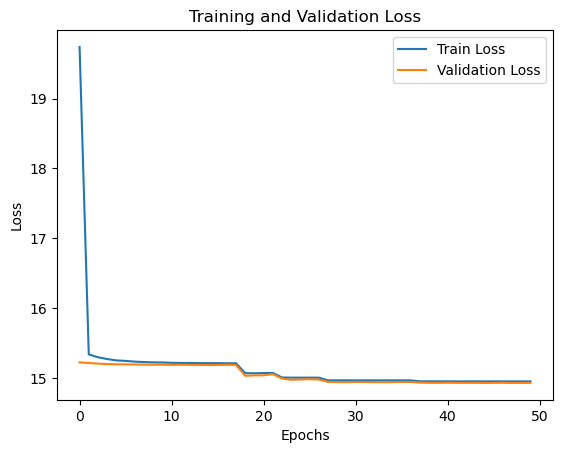

In [19]:
# Plot the training and validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [22]:
# Ensure the test data is in the correct shape and type
user_ids_test = test["user_id"].astype(np.int32).values.reshape(-1, 1)
item_ids_test = test["isbn"].astype(np.int32).values.reshape(-1, 1)
ratings_test = test["rating"].astype(np.float32).values

# Evaluate the model on the test data
test_loss = model_ncf.evaluate([user_ids_test, item_ids_test], ratings_test)
print(f"Test Loss: {test_loss}")

/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4709/4709 ━━━━━━━━━━━━━━━━━━━━ 173s 37ms/step - loss: 14.9889
Test Loss: 14.958467483520508


In [23]:
# Ensure the validation data is in the correct shape and type
user_ids_val = test["user_id"].astype(np.int32).values.reshape(-1, 1)
item_ids_val = test["isbn"].astype(np.int32).values.reshape(-1, 1)
ratings_val = test["rating"].astype(np.float32).values

# Evaluate on the validation set
val_loss = model_ncf.evaluate([user_ids_val, item_ids_val], ratings_val)
print(f"Validation Loss: {val_loss}")

4709/4709 ━━━━━━━━━━━━━━━━━━━━ 169s 36ms/step - loss: 14.9889
Validation Loss: 14.958467483520508


In [24]:
# Predict and calculate custom metrics like RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# Predictions
predictions_val = model_ncf.predict([user_ids_val, item_ids_val])
print(f"Prediction Validation: {predictions_val}")

predictions_test = model_ncf.predict([user_ids_test, item_ids_test])
print(f"Prediction Test: {predictions_test}")

# Calculate RMSE
rmse_val = sqrt(mean_squared_error(ratings_val, predictions_val))
rmse_test = sqrt(mean_squared_error(ratings_test, predictions_test))
print(f"Validation RMSE: {rmse_val}, Test RMSE: {rmse_test}")

  23/4709 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step    

/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4709/4709 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Prediction Validation: [[2.7590768]
 [2.7590768]
 [2.7590768]
 ...
 [2.7590768]
 [2.7590768]
 [2.7590768]]
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Prediction Test: [[2.7590768]
 [2.7590768]
 [2.7590768]
 ...
 [2.7590768]
 [2.7590768]
 [2.7590768]]
Validation RMSE: 3.8656690911112213, Test RMSE: 3.8656690911112213


In [25]:
# Choose a user ID (e.g., randomly select one from the dataset)
user_id = 3885

# Step 2: Retrieve the user's interactions (ratings)
# First, find the user's interactions in the validation set
user_val_indices = val[val["user_id"] == user_id].index
user_val_items = val.loc[user_val_indices, "isbn"].values

# Next, find items the user hasn't interacted with in the validation set
all_items = val["isbn"].unique()
user_not_interacted_items = np.setdiff1d(all_items, user_val_items)

# Step 3: Predict ratings for items the user hasn't interacted with
# Create arrays for user ID and item ID for prediction
user_ids_pred = np.array([user_id] * len(user_not_interacted_items))
item_ids_pred = np.array(user_not_interacted_items)

# Make predictions using the model
predictions_pred = model_ncf.predict([user_ids_pred, item_ids_pred])

# Step 4: Recommend the top-rated items to the user
# Combine item IDs with their predicted ratings
predictions_df = pd.DataFrame(
    {"isbn": user_not_interacted_items, "predicted_rating": predictions_pred.flatten()}
)

# Sort items by predicted rating in descending order
top_n_recommendations = predictions_df.sort_values(
    by="predicted_rating", ascending=False
).head(10)

# Now, you have the top 10 recommended books for the user
recommended_books = items.loc[
    top_n_recommendations["isbn"], ["book_title", "book_author"]
]

print("Top 10 Recommended Books for User", user_id)
print(recommended_books)

  64/2134 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step  

/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2134/2134 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


/usr/local/anaconda3/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Top 10 Recommended Books for User 3885
                                               book_title        book_author
3                                    Decision in Normandy       Carlo D'Este
117078                                Lady and the Outlaw      Joyce Brandon
117006                                     Girls Out Late  JACQUELINE WILSON
117008  Of Beetles and Angels : A Boy's Remarkable Jou...       Mawi Asgedom
117017  O Is for Outlaw (Kinsey Millhone Mysteries (Au...        Sue Grafton
117020                                        Hug a Teddy       Jim. Erskine
117023  The Asimov Chronicles: Fifty Years of Isaac As...       Isaac Asimov
117025          An Unsuitable Job for a Woman (BBC Radio)        P. D. James
117034  Bountiful Women: Large Women's Secrets for Liv...     Bonnie Bernell
117035  Evolution's End : Claiming the Potential of Ou...   Joseph C. Pearce
